In [1]:
import cv2
import numpy as np
from glob import glob
from os.path import join as pjoin
import matplotlib.pyplot as plt
from random import randint
from match_elements.matching import image_similarity

In [2]:
from keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(include_top=False, input_shape=(32, 32, 3))

Using TensorFlow backend.


In [3]:
def visualize_img_pair(pair):
    plt.subplot(1,2, 1)
    plt.imshow(pair[0])
    plt.subplot(1,2, 2)
    plt.imshow(pair[1])

In [4]:
pair_dir = '/home/ml/Data/result/visual_testing/matched_compos/cleaned'
img_paths = sorted(glob(pjoin(pair_dir, '*')))

name_pre = ''
pos_img_pairs = []
pos_path_pairs = []
for i, path in enumerate(img_paths):
    if i % 2 == 1:
        if img_paths[i - 1].split('/')[-1].split('_')[0] == path.split('/')[-1].split('_')[0]:
            pos_img_pairs.append([cv2.imread(img_paths[i - 1]), cv2.imread(path)])
            pos_path_pairs.append([img_paths[i - 1], path])

In [5]:
neg_img_pairs = []
neg_path_pairs = []
num = len(pos_img_pairs) - 1
for i, path_pair in enumerate(pos_path_pairs):
    r_id = randint(0, num)
    if r_id == i:
        r_id = (r_id + 1) % num
        
    neg_img_pairs.append([pos_img_pairs[i][0], pos_img_pairs[r_id][1]])
    neg_path_pairs.append([path_pair[0], pos_path_pairs[r_id][1]])

In [6]:
def calc_pairs_similarities(pairs):
    sims = {'dhash':[], 'ssim':[], 'surf':[], 'sift':[], 'resnet':[]}
    for pair in pairs:
        img1, img2 = pair
        sims['dhash'].append(image_similarity(img1, img2, method='dhash'))
        sims['ssim'].append(image_similarity(img1, img2, method='ssim', is_gray=True))
        sims['surf'].append(image_similarity(img1, img2, method='surf', draw_match=False, match_distance_ratio=1.3))
        sims['sift'].append(image_similarity(img1, img2, method='sift', draw_match=False, match_distance_ratio=1.3))
        sims['resnet'].append(image_similarity(img1, img2, method='resnet', resnet_model=resnet_model))
    return sims

In [7]:
pos_sims = calc_pairs_similarities(pos_img_pairs)

In [8]:
neg_sims = calc_pairs_similarities(neg_img_pairs)

In [9]:
def correct_ratio(sim_pos, sim_neg, threshold, method):
    pos_correct = 0
    for sim in sim_pos[method]:
        if sim >= threshold:
            pos_correct += 1
    correct_ratio_pos = pos_correct / len(sim_pos[method])
    
    neg_correct = 0
    for sim in sim_neg[method]:
        if sim < threshold:
            neg_correct += 1
    correct_ratio_neg = neg_correct / len(sim_neg[method])
    
    print("[%s] Positive Correctness: %.3f; Negative Correctness: %.3f" % (method, correct_ratio_pos, correct_ratio_neg))
    return correct_ratio_pos, correct_ratio_neg


def correctness_in_range(sim_pos, sim_neg, method, thresh_range=np.arange(0.5, 1, 0.1)):
    correctness = []
    for i in thresh_range:
        correctness.append(correct_ratio(sim_pos, sim_neg, i, method))
    return np.array(correctness)


def draw_correctness_curve(correctness, method):
    plt.title(method)
    plt.plot(thresh_range, correctness[:, 0], label='True Positive')
    plt.plot(thresh_range, correctness[:, 1], label='True Negative')
    plt.legend()
    plt.xlabel('Min Similarity Threshold')
    plt.ylabel('Score')

[dhash] Positive Correctness: 0.952; Negative Correctness: 0.390
[dhash] Positive Correctness: 0.712; Negative Correctness: 0.837
[dhash] Positive Correctness: 0.457; Negative Correctness: 0.971
[dhash] Positive Correctness: 0.137; Negative Correctness: 1.000
[dhash] Positive Correctness: 0.000; Negative Correctness: 1.000


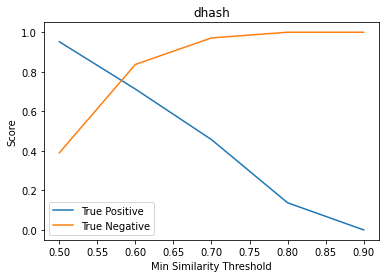

In [44]:
cor_dhash = correctness_in_range(pos_sims, neg_sims, 'dhash')
draw_correctness_curve(cor_dhash, 'dhash')